<a href="https://colab.research.google.com/github/ronenbendavid/IDC_NLP/blob/master/Asi_Assignment_4_NER_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4
Training a neural named entity recognition (NER) tagger using BERT.

In [1]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('version: {}, device: {}, device name: {}'.format(torch.__version__, device, torch.cuda.get_device_name(0)))

model_path='model_ex4'

version: 1.6.0+cu101, device: cuda, device name: Tesla T4


/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [23]:
!pip install transformers seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=06d7e35419787c07620080eaf7ad3b3de19b4b99f5a727c58555c1e222cfb531
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In this assignment you are required to build a full training and testing pipeline for a neural sequentail tagger for named entities, using BERT transformer, similar to assignment 3.

The dataset that you will be working on is called ReCoNLL 2003, which is a corrected version of the CoNLL 2003 dataset: https://www.clips.uantwerpen.be/conll2003/ner/

[Train data](https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing)

[Dev data](https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing)

[Test data](https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing)

As you can see, the annotated texts are labeled according to the IOB annotation scheme, for 3 entity types: Person, Organization, Location.

***(Already done in Assignment 3, so you may copy and paste it here)*** Write a funtion for reading the data from a single file (of the ones that are provided above). The function recieves a filepath and then it encodes every sentence individually using a pair of lists, one list contains the words and one list contains the tags. Each list pair will be added to a general list (data), which will be returned back from the function.

In [3]:
import requests
import re

tag_values = set()
def read_data(filepath):
    sentences = []
    labels = []

    result = re.compile(".*drive.google.com/file/d/([^/]*)/.*").match(filepath)
    if result:
      filepath = 'https://docs.google.com/uc?export=download&id={}'.format(result.group(1))
    print(filepath)

    response = requests.get(filepath)
    words = []
    tags = []

    for line in response.text.split('\n'):
        if not line:
            if len(words) > 0:
                sentences.append(words)
                labels.append(tags)
                tag_values.update(tags)
            words = []
            tags = []
        else:
            line = line.strip().split()
            words.append(line[0])
            tags.append(line[1])

    return sentences, labels

train_s, train_l = read_data('https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing')
dev_s, dev_l = read_data('https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing')
test_s, test_l = read_data('https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing')


https://docs.google.com/uc?export=download&id=1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz
https://docs.google.com/uc?export=download&id=1EAF-VygYowU1XknZhvzMi2CID65I127L
https://docs.google.com/uc?export=download&id=16gug5wWnf06JdcBXQbcICOZGZypgr4Iu


In [4]:
tag_values = list(tag_values)
tag_values.append("PAD")
list.sort(tag_values) # sort so we can reuse saved models
tag2idx = {t: i for i, t in enumerate(tag_values)}

Use Huggingface transformers:
https://github.com/huggingface/transformers

to process the data and train a BERT model (with a Linear layer on top) for NER.

Then, evaluate it on the Dev and Test data and report on results.

In [5]:
print(tag2idx)

{'B-LOC': 0, 'B-ORG': 1, 'B-PER': 2, 'I-LOC': 3, 'I-ORG': 4, 'I-PER': 5, 'O': 6, 'PAD': 7}


In [6]:
for token, label in zip(train_s[3], train_l[3]):
    print("{}\t{}".format(label, token))

B-LOC	England
O	were
O	all
O	out
O	for
O	326
O	in
O	their
O	first
O	innings
O	on
O	the
O	second
O	day
O	of
O	the
O	third
O	and
O	final
O	test
O	against
B-LOC	Pakistan
O	at
B-LOC	The
I-LOC	Oval
O	on
O	Friday
O	.


In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

torch.__version__

Using TensorFlow backend.


'1.6.0+cu101'

In [8]:
MAX_LEN = 75
bs = 32


In [9]:
import os
if os.path.exists('{}/vocab.txt'.format(model_path)):
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False).from_pretrained(model_path)
else:
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)    

In [10]:
def tokenize_and_preserve_labels(sentence, labels):
    tokenized_sentence = []
    tokenized_labels = []

    for word, label in zip(sentence, labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        tokenized_labels.extend([label] * n_subwords)

    return tokenized_sentence, tokenized_labels

In [11]:
tr_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(train_s, train_l)
]

val_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(dev_s, dev_l)
]

test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(test_s, test_l)
]

In [12]:
tr_tokenized_texts = [token_label_pair[0] for token_label_pair in tr_tokenized_texts_and_labels]
tr_labels = [token_label_pair[1] for token_label_pair in tr_tokenized_texts_and_labels]

val_tokenized_texts = [token_label_pair[0] for token_label_pair in val_tokenized_texts_and_labels]
val_labels = [token_label_pair[1] for token_label_pair in val_tokenized_texts_and_labels]

In [13]:
tr_inputs = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tr_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

val_inputs = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in val_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [14]:
tr_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in tr_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

val_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in val_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [15]:
tr_masks = [[float(i != 0.0) for i in ii] for ii in tr_inputs]

val_masks = [[float(i != 0.0) for i in ii] for ii in val_inputs]


In [16]:
tr_inputs = torch.tensor(tr_inputs)
tr_tags = torch.tensor(tr_tags)
tr_masks = torch.tensor(tr_masks)

val_inputs = torch.tensor(val_inputs)
val_tags = torch.tensor(val_tags)
val_masks = torch.tensor(val_masks)


In [17]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [18]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'3.0.2'

In [19]:
import os

if os.path.exists('{}/vocab.txt'.format(model_path)):
    model = BertForTokenClassification.from_pretrained(
        "bert-base-cased",
        num_labels=len(tag2idx),
        output_attentions = False,
        output_hidden_states = False
    ).from_pretrained(model_path)
    model.cuda()
    model.eval()
else:
    model = BertForTokenClassification.from_pretrained(
        "bert-base-cased",
        num_labels=len(tag2idx),
        output_attentions = False,
        output_hidden_states = False
    )
    model.cuda()    

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [20]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [37]:
import numpy as np
from tqdm import tqdm, trange
from seqeval.metrics import f1_score, accuracy_score

def train():

    ## Store the average loss after each epoch so we can plot them.
    loss_values, validation_loss_values = [], []

    for _ in trange(epochs, desc="Epoch"):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.

        # Put the model into training mode.
        model.train()
        # Reset the total loss for this epoch.
        total_loss = 0

        # Training loop
        for step, batch in enumerate(train_dataloader):
            # add batch to gpu
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            # Always clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()
            # forward pass
            # This will return the loss (rather than the model output)
            # because we have provided the `labels`.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
            # get the loss
            loss = outputs[0]
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # track train loss
            total_loss += loss.item()
            # Clip the norm of the gradient
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            # update parameters
            optimizer.step()
            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        print("Average train loss: {}".format(avg_train_loss))

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)


        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # Put the model into evaluation mode
        model.eval()
        # Reset the validation loss for this epoch.
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        predictions , true_labels = [], []
        for batch in valid_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have not provided labels.
                outputs = model(b_input_ids, token_type_ids=None,
                                attention_mask=b_input_mask, labels=b_labels)
            # Move logits and labels to CPU
            logits = outputs[1].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            eval_loss += outputs[0].mean().item()
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.extend(label_ids)

        eval_loss = eval_loss / len(valid_dataloader)
        validation_loss_values.append(eval_loss)
        print("Validation loss: {}".format(eval_loss))
        pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                     for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
        valid_tags = [tag_values[l_i] for l in true_labels
                                      for l_i in l if tag_values[l_i] != "PAD"]
        print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags) if valid_tags else "Unknown"))
        print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags) if valid_tags else "Unknown"))
        print()
        
    return loss_values, validation_loss_values


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def evaluate(loss_values, validation_loss_values):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(loss_values, 'b-o', label="training loss")
    plt.plot(validation_loss_values, 'r-o', label="validation loss")

    # Label the plot.
    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Average train loss: 0.00917347815438089


Epoch:   7%|▋         | 1/15 [00:22<05:20, 22.89s/it]

Validation loss: 0.10482017090544105
Validation Accuracy: 0.9769274057400112
Validation F1-Score: 0.9132947976878613

Average train loss: 0.012894714594056661


Epoch:  13%|█▎        | 2/15 [00:46<04:59, 23.03s/it]

Validation loss: 0.10984380729496479
Validation Accuracy: 0.9763646595385481
Validation F1-Score: 0.9162702188392007

Average train loss: 0.009535771949132058


Epoch:  20%|██        | 3/15 [01:09<04:38, 23.23s/it]

Validation loss: 0.13782358495518565
Validation Accuracy: 0.9743012567998499
Validation F1-Score: 0.9077069457659372

Average train loss: 0.006640693183395673


Epoch:  27%|██▋       | 4/15 [01:34<04:18, 23.48s/it]

Validation loss: 0.10042905015870929
Validation Accuracy: 0.9793659726130182
Validation F1-Score: 0.9244741873804971

Average train loss: 0.0050863203730180185


Epoch:  33%|███▎      | 5/15 [01:58<03:57, 23.77s/it]

Validation loss: 0.13274852884933352
Validation Accuracy: 0.9767398236728568
Validation F1-Score: 0.9171852561033986

Average train loss: 0.004068769956938922


Epoch:  40%|████      | 6/15 [02:23<03:36, 24.04s/it]

Validation loss: 0.14080450125038624
Validation Accuracy: 0.9776777340086288
Validation F1-Score: 0.9258555133079849

Average train loss: 0.0036251623067073526


Epoch:  47%|████▋     | 7/15 [02:47<03:13, 24.24s/it]

Validation loss: 0.11981900595128536
Validation Accuracy: 0.9804914650159445
Validation F1-Score: 0.9298329355608592

Average train loss: 0.0030492729385679755


Epoch:  53%|█████▎    | 8/15 [03:12<02:50, 24.34s/it]

Validation loss: 0.11401298828423023
Validation Accuracy: 0.9810542112174077
Validation F1-Score: 0.9301435406698565

Average train loss: 0.00171558431413194


Epoch:  60%|██████    | 9/15 [03:36<02:26, 24.39s/it]

Validation loss: 0.12332085706293583
Validation Accuracy: 0.978803226411555
Validation F1-Score: 0.9255725190839694

Average train loss: 0.0013277659679509022


Epoch:  67%|██████▋   | 10/15 [04:01<02:02, 24.44s/it]

Validation loss: 0.11739218141883612
Validation Accuracy: 0.9810542112174077
Validation F1-Score: 0.9312320916905444

Average train loss: 0.0006823728948471729


Epoch:  73%|███████▎  | 11/15 [04:26<01:37, 24.47s/it]

Validation loss: 0.11431875848211348
Validation Accuracy: 0.9823672856874883
Validation F1-Score: 0.935823754789272

Average train loss: 0.0016747613344870677


Epoch:  80%|████████  | 12/15 [04:50<01:13, 24.49s/it]

Validation loss: 0.11402547359466553
Validation Accuracy: 0.9823672856874883
Validation F1-Score: 0.93621103117506

Average train loss: 0.0007746786400358277


Epoch:  87%|████████▋ | 13/15 [05:15<00:49, 24.52s/it]

Validation loss: 0.10834612371399999
Validation Accuracy: 0.9819921215531795
Validation F1-Score: 0.932503590234562

Average train loss: 0.000762257383427244


Epoch:  93%|█████████▎| 14/15 [05:39<00:24, 24.54s/it]

Validation loss: 0.11107898713089526
Validation Accuracy: 0.9819921215531795
Validation F1-Score: 0.9342925659472421

Average train loss: 0.0006093498470198193


Epoch: 100%|██████████| 15/15 [06:04<00:00, 24.29s/it]

Validation loss: 0.11123637459240854
Validation Accuracy: 0.9819921215531795
Validation F1-Score: 0.9342925659472421



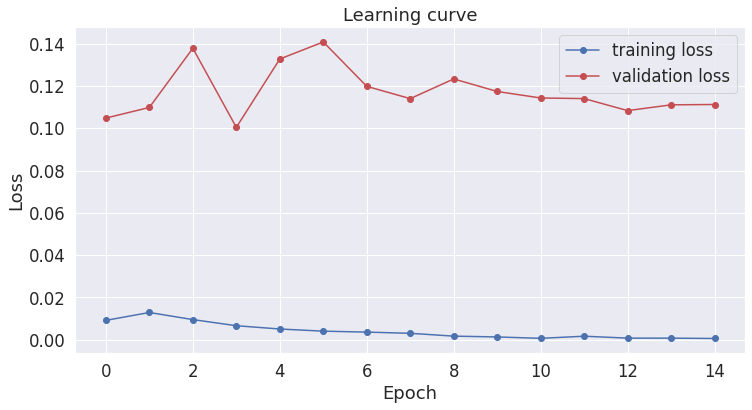

In [40]:
import os


## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

if not os.path.exists('{}/vocab.txt'.format(model_path)):
    loss_values, validation_loss_values = train()
    evaluate(loss_values, validation_loss_values)
    model.save_pretrained(model_path)  # save
    tokenizer.save_pretrained(model_path)  # save


In [29]:
import numpy as np

def analyze_sentence(sentence):
    tokenized_sentence = tokenizer.encode(sentence)
    input_ids = torch.tensor([tokenized_sentence]).cuda()
    
    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    # join bpe split tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)

    return new_tokens, new_labels

In [30]:
def align_sentence_labels(sentence, labels):
    tokenized_sentence = []
    tokenized_labels = []

    for word, label in zip(sentence, labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        tokenized_labels.extend([label] * n_subwords)

        new_tokens, new_labels = [], []
        for token, label in zip(tokenized_sentence, tokenized_labels):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(label)
                new_tokens.append(token)

    return new_tokens, new_labels

In [41]:
# test_sentence = """
# Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
# reporter for the network, about protests in Minnesota and elsewhere. 
# """

test_sentence = """
This is Assaf Sinvani notebook. 
it's part of the preparation for the NLP course in the IDC, Herzelia Interdisciplinary Center
"""

# test_sentence = """
# So, I would like to fly out sometime tonight and fly back in the evening in 4 days.
# From I’m looking to go to Denver. I’m flying out of San Francisco.
# """

# test_sentence = """
# I would like to book a room in the Park Hyatt Aviara Resort and it costs $279 per night.
# It’s rated 4.8 stars. It offers an 18-hole golf course, an outdoor pool & tennis courts plus a spa & fine dining.
# """

In [42]:
new_tokens, new_labels = analyze_sentence(test_sentence)
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
O	This
O	is
B-PER	Assaf
I-PER	Sinvani
O	notebook
O	.
O	it
O	'
O	s
O	part
O	of
O	the
O	preparation
O	for
O	the
B-ORG	NLP
O	course
O	in
O	the
B-LOC	IDC
O	,
B-LOC	Herzelia
I-ORG	Interdisciplinary
I-ORG	Center
O	[SEP]


In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

def evaluate_dataset(model, sentences, labels):
    y_true = np.array([])
    y_pred = np.array([])

    # build array for true labels and predicted labels
    for (sentence, labels) in zip(sentences, labels):
        _, pred_labels = analyze_sentence(sentence)

        y_true = np.append(y_true, [tag2idx[l] for l in labels])
        y_pred = np.append(y_pred, [tag2idx[l] for l in pred_labels[1:-1]])
        

    # use sklearn to calculate precision and recall for every label
    report = classification_report(y_true, y_pred, labels=list(tag2idx.values()), target_names=list(tag2idx.keys()), digits=4, output_dict=True, zero_division=False)
    precision = [report[label]['precision'] for label in tag2idx.keys()]
    recall = [report[label]['recall'] for label in tag2idx.keys()]

    # use sklearn to calculate precision and recall for all labels except O
    report = classification_report(y_true != tag2idx['O'], y_pred != tag2idx['O'], target_names=['O', 'OTHER'], digits=4, output_dict=True)
    precision.append(report['OTHER']['precision'])
    recall.append(report['OTHER']['recall'])

    return precision, recall


def evaluate_model(model):
    precision_dev, recall_dev = evaluate_dataset(model, dev_s, dev_l)
    precision_test, recall_test = evaluate_dataset(model, test_s, test_l)

    rows = ['precision dev', 'precision test', 'recall dev', 'recall test']
    columns = list(tag2idx.keys())
    columns.append('Not O')

    df = pd.DataFrame(np.array([precision_dev, precision_test, recall_dev, recall_test]), index=rows, columns=columns)
    print(df)

  

In [44]:
pd.options.display.max_columns = None
pd.options.display.width = 1000

evaluate_model(model)

                   B-LOC     B-ORG     B-PER     I-LOC     I-ORG     I-PER         O  PAD     Not O
precision dev   0.848649  0.813725  0.772277  0.928571  0.948052  0.900826  0.939543  0.0  0.928673
precision test  0.811111  0.882653  0.823370  0.911111  0.891473  0.917051  0.934902  0.0  0.931559
recall dev      0.857923  0.494048  0.780000  0.565217  0.629310  0.694268  0.983850  0.0  0.768595
recall test     0.851312  0.494286  0.698157  0.773585  0.575000  0.672297  0.986295  0.0  0.730907


10 Epochs
```
B-LOC     B-ORG     B-PER     I-LOC     I-ORG     I-PER         O  PAD     Not O
precision dev   0.747664  0.849057  0.776119  1.000000  0.948052  0.911111  0.947187  0.0  0.912517
precision test  0.713942  0.810811  0.815013  0.967742  0.892308  0.900862  0.940488  0.0  0.903846
recall dev      0.874317  0.535714  0.780000  0.434783  0.629310  0.783439  0.979005  0.0  0.800472
recall test     0.865889  0.514286  0.700461  0.566038  0.580000  0.706081  0.979443  0.0  0.757160
```



25 Epochs
```
                   B-LOC     B-ORG     B-PER     I-LOC     I-ORG     I-PER         O  PAD     Not O
precision dev   0.848649  0.813725  0.772277  0.928571  0.948052  0.900826  0.939543  0.0  0.928673
precision test  0.811111  0.882653  0.823370  0.911111  0.891473  0.917051  0.934902  0.0  0.931559
recall dev      0.857923  0.494048  0.780000  0.565217  0.629310  0.694268  0.983850  0.0  0.768595
recall test     0.851312  0.494286  0.698157  0.773585  0.575000  0.672297  0.986295  0.0  0.730907
```


**Good luck!**